# Домашняя работа по Лекции #1

Тема: **Введение в нейронные сети**

Задания:
- №1 Обучить FFN разделять точки на два класса нелинейно
- №2 Обучить FFN для аппроксимации сложной функции
- №3 Обучить FFN для классификации изображения MNIST

## Задание №1

Задача: обучить FFN через PyTorch для разделения облака точек на два класса, нелинейно

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import expit  # Сигмоида

In [25]:
# Функция для генерации данных в виде треугольника
def generate_triangle_data(n_samples=100):
    np.random.seed(42)
    points = []
    labels = []

    for _ in range(n_samples):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(0, 1)

        # Условие для разделения классов
        if y > abs(x):
            labels.append(1)  # Верхняя часть (синий)
        else:
            labels.append(0)  # Нижняя часть (оранжевый)
        points.append([x, y])

    return np.array(points), np.array(labels)

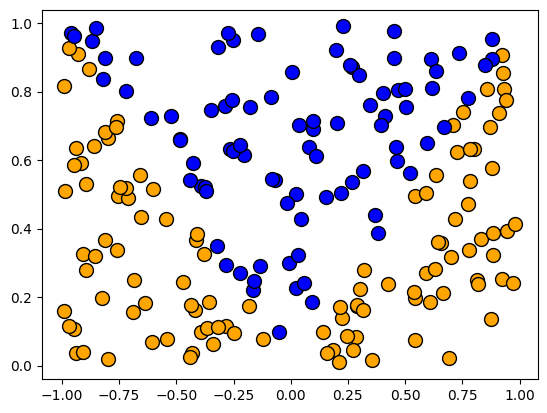

In [26]:
# Генерируем данные
X, y = generate_triangle_data(200)

# Разбиваем на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Визуализация данных
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', edgecolors='black', s=100)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', edgecolors='black', s=100)
plt.show()

### Попытка решения задачи через Логистическую регрессию.

Epoch 0, Loss: 0.6936
Epoch 100, Loss: 0.6398
Epoch 200, Loss: 0.6032
Epoch 300, Loss: 0.5767
Epoch 400, Loss: 0.5572
Epoch 500, Loss: 0.5426
Epoch 600, Loss: 0.5315
Epoch 700, Loss: 0.5229
Epoch 800, Loss: 0.5162
Epoch 900, Loss: 0.5109
Точность модели: 0.62


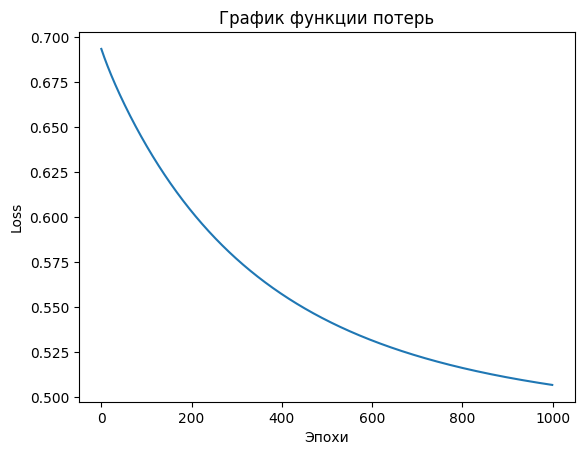

In [27]:
# Логистическая функция (сигмоида)
def sigmoid(z):
    return expit(z)  # Альтернатива: return 1 / (1 + np.exp(-z))

# Функция потерь (логистическая)
def loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))

# Градиентный спуск
def train_logistic_regression(X, y, lr=0.1, epochs=1000):
    m, n = X.shape
    X = np.c_[np.ones((m, 1)), X]  # Добавляем смещение (bias)
    theta = np.random.randn(n + 1) * 0.01  # Инициализация параметров

    losses = []
    for epoch in range(epochs):
        z = np.dot(X, theta)
        y_pred = sigmoid(z)
        grad = np.dot(X.T, (y_pred - y)) / m  # Градиент
        theta -= lr * grad  # Обновление параметров

        loss_value = loss(y, y_pred)
        losses.append(loss_value)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_value:.4f}")

    return theta, losses

# Предсказание классов
def predict(X, theta):
    X = np.c_[np.ones((X.shape[0], 1)), X]  # Добавляем смещение
    return (sigmoid(np.dot(X, theta)) >= 0.5).astype(int)

# Обучение модели
theta, losses = train_logistic_regression(X_train, y_train)

# Оценка точности
y_pred_test = predict(X_test, theta)
accuracy = np.mean(y_pred_test == y_test)
print(f"Точность модели: {accuracy:.2f}")

# Визуализация ошибки
plt.plot(losses)
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.show()

Text(0.5, 1.0, 'Граница принятия решения логистической регрессии')

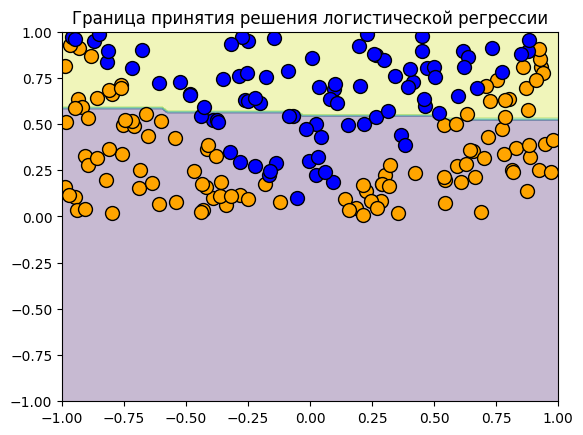

In [28]:
# Визуализация границы принятия решения
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_pred = predict(grid, theta).reshape(xx.shape)

plt.contourf(xx, yy, grid_pred, alpha=0.3)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', edgecolors='black', s=100)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', edgecolors='black', s=100)
plt.title("Граница принятия решения логистической регрессии")

### Решение задачи через полносвязную нейронную сеть

In [5]:
# Преобразуем в PyTorch тензоры
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [6]:
# Определяем простую нейросеть
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [7]:
# Создаем модель
model = SimpleNN()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train_torch)
    loss = loss_fn(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 0.7105
Epoch 100, Loss: 0.3315
Epoch 200, Loss: 0.1482
Epoch 300, Loss: 0.0983
Epoch 400, Loss: 0.0759
Epoch 500, Loss: 0.0629
Epoch 600, Loss: 0.0541
Epoch 700, Loss: 0.0474
Epoch 800, Loss: 0.0420
Epoch 900, Loss: 0.0376


In [8]:
# Проверка точности
with torch.no_grad():
    y_pred_test = model(X_test_torch).round()
    accuracy = (y_pred_test.eq(y_test_torch).sum().item()) / y_test_torch.shape[0]
    print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97


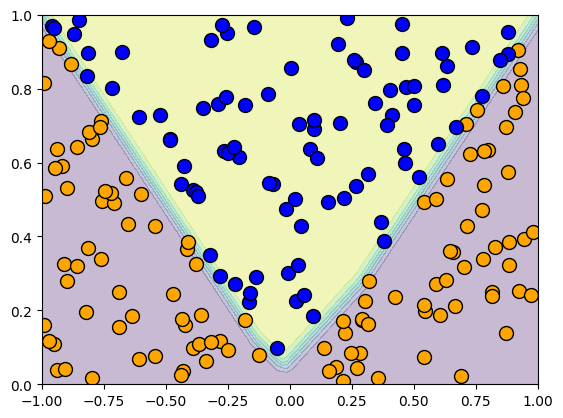

In [9]:
# Визуализация границы принятия решения
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(0, 1, 100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
y_grid_pred = model(grid).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, y_grid_pred, alpha=0.3)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='orange', edgecolors='black', s=100)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', edgecolors='black', s=100)
plt.show()

## Задание №2

Задача: Обучить нейронную сеть аппроксимировать сложную математическую функцию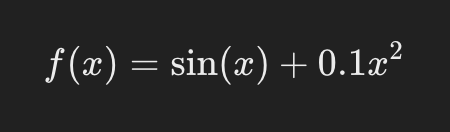

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
# Генерация данных
np.random.seed(42)
x = np.linspace(-10, 10, 500).reshape(-1, 1)
y = np.sin(x) + 0.1 * x**2

In [12]:
# Преобразование данных в тензоры PyTorch
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [13]:
# Определение нейронной сети
class FunctionApproximator(nn.Module):
    def __init__(self):
        super(FunctionApproximator, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
# Создание модели и определение функции потерь и оптимизатора
model = FunctionApproximator()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch 0, Loss: 14.0917
Epoch 500, Loss: 0.2310
Epoch 1000, Loss: 0.2286
Epoch 1500, Loss: 0.2286
Epoch 2000, Loss: 0.2286
Epoch 2500, Loss: 0.0885
Epoch 3000, Loss: 0.0034
Epoch 3500, Loss: 0.0039
Epoch 4000, Loss: 0.0029
Epoch 4500, Loss: 0.0049


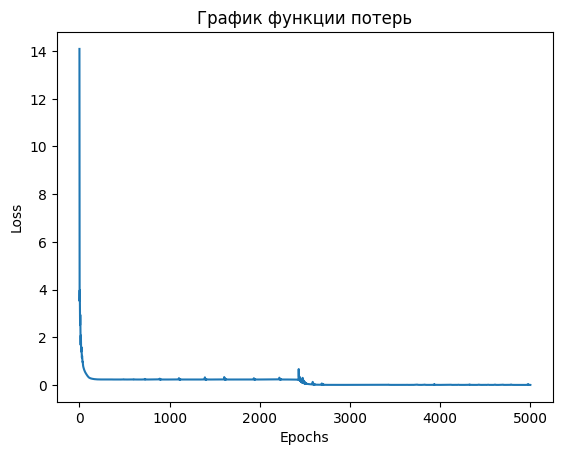

In [15]:
# Обучение модели
epochs = 5000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Визуализация функции потерь
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("График функции потерь")
plt.show()

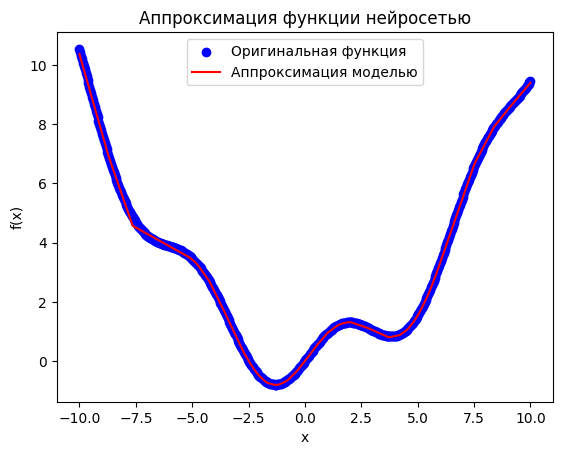

In [16]:
# Проверка модели
with torch.no_grad():
    y_pred = model(x_tensor).numpy()

# Визуализация результата
plt.scatter(x, y, label="Оригинальная функция", color='blue')
plt.plot(x, y_pred, label="Аппроксимация моделью", color='red')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("Аппроксимация функции нейросетью")
plt.show()

## Задание №3

Задача: Создать и обучить полносвязную нейронную сеть для распознавания цифр MNIST

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [18]:
# Гиперпараметры
batch_size = 64
epochs = 10
learning_rate = 0.001

In [19]:
# Загрузка данных (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Определение нейросети
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# Инициализация модели, функции потерь и оптимизатора
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.3258
Epoch [2/10], Loss: 0.0150
Epoch [3/10], Loss: 0.0121
Epoch [4/10], Loss: 0.2455
Epoch [5/10], Loss: 0.0294
Epoch [6/10], Loss: 0.0131
Epoch [7/10], Loss: 0.0063
Epoch [8/10], Loss: 0.0571
Epoch [9/10], Loss: 0.0356
Epoch [10/10], Loss: 0.0186


In [22]:
# Оценка точности
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 97.19%


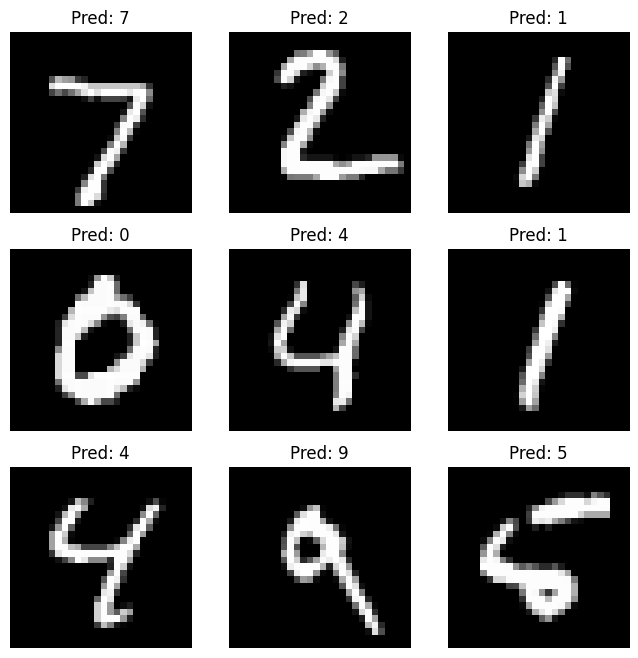

In [23]:
# Визуализация предсказаний
images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f'Pred: {predictions[i].item()}')
    ax.axis('off')
plt.show()